The given dataset comes from musical songs domain. It consists of about 1/2 Million songs from 20th and 21st century. The task is to predict the year the song was released given the musical content of the song.   

Using the Adaboost algorithm, I achieved a mean-absolute-error of 6.15 on test data. The best MAE achieved by students in the course was 5.66. The worst was 8.42. 


In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
import csv

In [3]:
df = sio.loadmat('MSdata.mat')

In [4]:
df.keys()

dict_keys(['trainy', 'trainx', '__header__', 'testx', '__globals__', '__version__'])

In [5]:
trainx = df.get('trainx')
trainy = df.get('trainy')
testx = df.get('testx')

In [6]:
df.get('__header__')

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Nov 12 22:59:49 2017'

In [7]:
trainx.shape

(463715, 90)

In [8]:
train_df = np.concatenate((trainx, trainy), axis = 1)

In [9]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    trainx, trainy, test_size = 0.25, random_state = 0)

In [10]:
# Linear regression for training set; no preprocessing

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.800460937515051

In [11]:
# Lasso regression; no preprocessing

# search for optimal hyperparameter
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lasso_errors = []

for alpha in alphas: 
    regr_lasso = Lasso(alpha = alpha)
    regr_lasso.fit(X_train, y_train)
    y_lasso = regr_lasso.predict(X_test)
    lasso_errors.append(mean_absolute_error(y_test, y_lasso))

print(lasso_errors)

[6.80046196705905, 6.800471331903435, 6.800568136876168, 6.802258277081394, 6.8350316597582, 7.422104901014987, 7.934186024899633]


Lasso regularization didn't do much better than simple linear regression

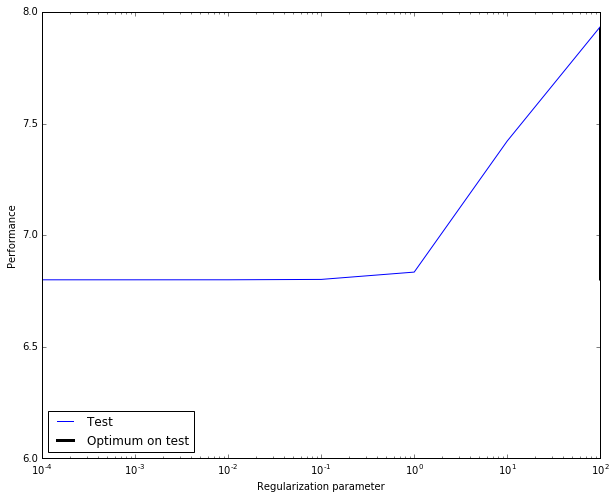

In [12]:
alpha_optim=alphas[np.argmax(lasso_errors)]

plt.figure(figsize=(10,8))

plt.semilogx(alphas, lasso_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(lasso_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([6, 8])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

In [33]:
# Ridge regression; no preprocessing

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
ridge_errors = []

for alpha in alphas: 
    regr_ridge = Ridge(alpha = alpha)
    regr_ridge.fit(X_train, y_train)
    y_ridge = regr_ridge.predict(X_test)
    ridge_errors.append(mean_absolute_error(y_test, y_ridge))

print(ridge_errors)

[6.8004609375155605, 6.800460937519738, 6.800460937561922, 6.800460937983665, 6.80046094220086, 6.800460984373035, 6.800461406093775]


Ridge regularization also did not offer any improvement

In [54]:
# AdaBoost; no preprocessing

start_time = time.time()
rng = np.random.RandomState(1)
regr_adaboost200 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators = 100, random_state = rng)
regr_adaboost200.fit(X_train, y_train.ravel())
y_adaboost = regr_adaboost200.predict(X_test)
print(mean_absolute_error(y_test, y_adaboost))
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

5.930560946786395
--- 11636.70404291153 seconds ---


Adaboost offered significant improvement in MAE (but took a really long time to run) 

In [64]:
# produce prediction years based on AdaBoost with 200 estimators
test_adaboost200 = regr_adaboost200.predict(testx)

In [71]:
# AdaBoost 200 prediction

test_adaboost200_int = test_adaboost200.astype(np.int64)
testy_adaboost = pd.DataFrame({'prediction':test_adaboost200_int})

# Save adaboost predictions to csv to be uploaded into Kaggle
testy_adaboost.to_csv('testy_adaboost200.csv')

numpy.int64

In [77]:
testy_adaboost = pd.DataFrame({'dataid': list(range(1, testx.shape[0]+1)), 'prediction':test_adaboost200_int})
testy_adaboost.to_csv('testy_adaboost200.csv')

In [46]:
# AdaBoost; no preprocessing; default n_estimators = 50

start_time = time.time()
rng = np.random.RandomState(1)
regr_adaboost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = rng)
regr_adaboost.fit(X_train, y_train.ravel())
y_adaboost = regr_adaboost.predict(X_test)
print(mean_absolute_error(y_test, y_adaboost))
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

6.055758265835124
--- 3132.78430891037 seconds ---


In [35]:
timbre_avg = trainx[:, :12]
timbre_cov = trainx[:, 12:]